#  Pets adoption competition
(by Elena Fominskaya)

2019


## Submit notebook

In [72]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt

import pprint
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed

from sklearn.linear_model import Ridge, RidgeClassifier

import cv2

from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import linear_model, metrics
from multiprocessing import Pool

import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
import lightgbm as lgb

%matplotlib inline

np.random.seed(seed=300)
warnings.filterwarnings('ignore')

split_char = '/'

SUBMiT = True
ONLY1 = True
n_splits = 5
n_comp = 32

In [2]:
os.listdir('../input')

['.DS_Store',
 'densenet-keras',
 'petfinder-adoption-prediction',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'vgg-keras']

In [3]:
train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')
sample_submission = pd.read_csv('../input/petfinder-adoption-prediction/test/sample_submission.csv')

In [19]:
labels_breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
labels_state = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
labels_color = pd.read_csv('../input/petfinder-adoption-prediction/state_labels.csv')

In [4]:
splits = list(StratifiedKFold(n_splits=n_splits, 
                                  shuffle=True, 
                                  random_state=1337).split(train, train['AdoptionSpeed'].values))
encod_splits = list(StratifiedKFold(n_splits=n_splits*2, 
                                  shuffle=True, 
                                  random_state=1337).split(train, train['AdoptionSpeed'].values))

In [5]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

class OptimizedRounder_v3(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        Xsort = np.sort(X)
        ysort = np.sort(y)
        bounds = []
        for ibound in range(5-1):
            iy = len(ysort[ysort <= ibound])
            bounds.append(Xsort[iy])
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = bounds #[0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_ ['x']

# Extract features from profile images

In [6]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, file):
    image = cv2.imread(f'{path}{file}')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [7]:
img_size = 256
batch_size = 32

In [8]:
if SUBMiT:
    inp = Input((256,256,3))
    backbone = DenseNet121(input_tensor = inp, 
                           weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                           include_top = False)
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
    x = AveragePooling1D(4)(x)
    out = Lambda(lambda x: x[:,:,0])(x)

    m = Model(inp,out)

In [9]:
%%time
if SUBMiT and ONLY1:
    def load_image(path, pet_id):
        image = cv2.imread(f'{path}{pet_id}-1.jpg')
        new_image = resize_to_square(image)
        new_image = preprocess_input(new_image)
        return new_image

    pet_ids = train['PetID'].values
    n_batches = len(pet_ids) // batch_size + 1

    features = {}
    for b in range(n_batches):
        start = b*batch_size
        end = (b+1)*batch_size
        batch_pets = pet_ids[start:end]
        batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
        for i,pet_id in enumerate(batch_pets):
            try:
                batch_images[i] = load_image("../input/petfinder-adoption-prediction/train_images/", pet_id)
            except:
                pass
        batch_preds = m.predict(batch_images)
        for i,pet_id in enumerate(batch_pets):
            features[pet_id] = batch_preds[i]
            
    train_feats = pd.DataFrame.from_dict(features, orient='index')
    train_feats.columns = [f'pic_{i}' for i in range(train_feats.shape[1])]     
    
    pet_ids = test['PetID'].values
    n_batches = len(pet_ids) // batch_size + 1

    features = {}
    for b in range(n_batches):
        start = b*batch_size
        end = (b+1)*batch_size
        batch_pets = pet_ids[start:end]
        batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
        for i,pet_id in enumerate(batch_pets):
            try:
                batch_images[i] = load_image("../input/petfinder-adoption-prediction/test_images/", pet_id)
            except:
                pass
        batch_preds = m.predict(batch_images)
        for i,pet_id in enumerate(batch_pets):
            features[pet_id] = batch_preds[i]    
            
    test_feats = pd.DataFrame.from_dict(features, orient='index')
    test_feats.columns = [f'pic_{i}' for i in range(test_feats.shape[1])]

    train_feats = train_feats.reset_index()
    train_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

    test_feats = test_feats.reset_index()
    test_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

    all_ids = pd.concat([train, test], axis=0, ignore_index=True, sort=False)[['PetID']]
    all_ids.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [12]:
train_feats.shape, test_feats.shape

((58311, 257), (15040, 257))

In [13]:
cols = [f'pic_{i}' for i in range(256)]
features_df = pd.concat([train_feats[cols],test_feats[cols]],axis=0)

svd = TruncatedSVD(n_components=n_comp, random_state=1337)
svd.fit(features_df.values)
X = svd.transform(train_feats[cols].values)
X = pd.DataFrame(X)

X = X.add_prefix('IMG_SVD_')
train_svd_feats = pd.concat([X,train_feats['PetID']], axis=1)

X_test = svd.transform(test_feats[cols].values)
X_test = pd.DataFrame(X_test)
X_test = X_test.add_prefix('IMG_SVD_')
test_svd_feats = pd.concat([X_test,test_feats['PetID']], axis=1)

train_svd_feats.shape, test_svd_feats.shape

((58311, 9), (15040, 9))

In [14]:
train_svd_feats.head()

,IMG_SVD_0,IMG_SVD_1,IMG_SVD_2,IMG_SVD_3,IMG_SVD_4,IMG_SVD_5,IMG_SVD_6,IMG_SVD_7,PetID
0,8.343090,-2.205993,-1.044169,-0.019520,0.386543,0.424787,-0.462856,-0.042418,0008c5398
1,9.020251,-2.011501,-0.483274,-0.453309,-0.038329,0.267669,-0.288367,-0.162610,0008c5398
2,9.260867,-2.088719,-0.680421,-0.158262,-0.494183,0.460680,-0.444492,-0.076958,0008c5398
3,8.448920,-1.815336,-0.075091,-0.465325,-0.293431,0.418470,-0.750670,0.426511,0008c5398
4,9.017217,-2.295269,-0.753223,-0.804243,0.083241,0.347591,-0.617576,0.280203,0008c5398


## Aggregate image features via PetID

In [16]:
aggregates = ['min', 'max', 'mean']

train_img_features_gr = train_svd_feats.groupby(['PetID']).agg(aggregates)
train_img_features_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in train_img_features_gr.columns.tolist()])
train_img_features_gr = train_img_features_gr.reset_index()

test_img_features_gr = test_svd_feats.groupby(['PetID']).agg(aggregates)
test_img_features_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in test_img_features_gr.columns.tolist()])
test_img_features_gr = test_img_features_gr.reset_index()

In [17]:
test_img_features_gr.shape

(3821, 25)

In [18]:
test_img_features_gr.head()

,PetID,IMG_SVD_0_MIN,IMG_SVD_0_MAX,IMG_SVD_0_MEAN,IMG_SVD_1_MIN,IMG_SVD_1_MAX,IMG_SVD_1_MEAN,IMG_SVD_2_MIN,IMG_SVD_2_MAX,IMG_SVD_2_MEAN,...,IMG_SVD_4_MEAN,IMG_SVD_5_MIN,IMG_SVD_5_MAX,IMG_SVD_5_MEAN,IMG_SVD_6_MIN,IMG_SVD_6_MAX,IMG_SVD_6_MEAN,IMG_SVD_7_MIN,IMG_SVD_7_MAX,IMG_SVD_7_MEAN
0,000c21f80,8.266394,8.992180,8.679969,-1.839708,-1.378864,-1.627497,-1.315016,0.508117,-0.576161,...,-0.129958,-0.456167,0.162809,-0.048228,-0.427921,0.104698,-0.109869,-0.463169,1.001961,0.052472
1,001d503e8,8.593082,8.593082,8.593082,-1.897559,-1.897559,-1.897559,0.636667,0.636667,0.636667,...,-0.034670,0.284392,0.284392,0.284392,0.040738,0.040738,0.040738,-0.287882,-0.287882,-0.287882
2,001ec8d5b,8.417737,10.644456,9.385986,-2.095926,0.620584,-0.867936,-0.149678,0.963932,0.417218,...,-0.133897,-0.344843,0.588339,0.161594,-0.202701,0.728832,0.318508,-1.680404,0.305559,-0.523323
3,002d58f95,7.562668,9.731317,8.957210,-2.213350,0.550802,-0.834804,0.145010,1.164042,0.661752,...,-0.412701,-0.916470,0.666224,-0.475506,-0.634505,0.578075,0.141526,-0.404873,1.274214,0.155557
4,004682b50,7.477994,9.548469,8.487201,0.431526,1.470680,0.970240,-1.797397,0.418308,-0.918473,...,0.158515,-0.322247,0.331555,-0.045564,-0.378168,0.594061,0.056038,-1.039991,-0.899930,-0.960168


# Load metadatas and sentiment datas

In [20]:
train_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_sentiment/*.json'))

print(f'num of train images files: {len(train_image_files)}')
print(f'num of train metadata files: {len(train_metadata_files)}')
print(f'num of train sentiment files: {len(train_sentiment_files)}')


test_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_sentiment/*.json'))

print(f'num of test images files: {len(test_image_files)}')
print(f'num of test metadata files: {len(test_metadata_files)}')
print(f'num of test sentiment files: {len(test_sentiment_files)}')

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


### Train

In [21]:
# Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

# Metadata:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / train_df_ids.shape[0]:.3f}')

# Sentiment:
train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / train_df_ids.shape[0]:.3f}')

(14993, 1)
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


### Test

In [22]:
# Images:
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

# Metadata:
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(
    lambda x: x.split(split_char)[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(
    test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / test_df_ids.shape[0]:.3f}')

# Sentiment:
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(
    lambda x: x.split(split_char)[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / test_df_ids.shape[0]:.3f}')

(3948, 1)
3821
fraction of pets with metadata: 0.968
3815
fraction of pets with sentiment: 0.966


## Extract features from json files

In [23]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        self.extract_sentiment_text = False
    
    def open_json_file(self, filename):
        with open(filename, 'r', encoding='utf-8') as f:
            json_file = json.load(f)
        return json_file
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)
        
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns')
        file_sentences_sentiment_df = pd.DataFrame(
            {
                'magnitude_sum': file_sentences_sentiment['magnitude'].sum(axis=0),
                'score_sum': file_sentences_sentiment['score'].sum(axis=0),
                'magnitude_mean': file_sentences_sentiment['magnitude'].mean(axis=0),
                'score_mean': file_sentences_sentiment['score'].mean(axis=0),
                'magnitude_min': file_sentences_sentiment['magnitude'].min(axis=0),
                'score_min': file_sentences_sentiment['score'].min(axis=0),
                'magnitude_max': file_sentences_sentiment['magnitude'].max(axis=0),
                'score_max': file_sentences_sentiment['score'].max(axis=0),
                'magnitude_var': file_sentences_sentiment['magnitude'].var(axis=0),
                'score_var': file_sentences_sentiment['score'].var(axis=0),

            }, index=[0]
        )
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        df_sentiment = pd.concat([df_sentiment, file_sentences_sentiment_df], axis=1)
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations']
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = f'../input/petfinder-adoption-prediction/{mode}_sentiment/{pet_id}.json'
    try:
        sentiment_file = pet_parser.open_json_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob(f'../input/petfinder-adoption-prediction/{mode}_metadata/{pet_id}*.json'))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_json_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True)

    dfs = [df_sentiment, dfs_metadata]
    
    return dfs

pet_parser = PetFinderParser()

In [24]:
%%time
if  SUBMiT:
    train_pet_ids = train.PetID.unique()
    test_pet_ids = test.PetID.unique()

    dfs_train = Parallel(n_jobs=-1, verbose=1)(
        delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

    train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
    train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

    train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True)
    train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True)

    print(train_dfs_sentiment.shape, train_dfs_metadata.shape)

    dfs_test = Parallel(n_jobs=-1, verbose=1)(
        delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

    test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
    test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

    test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True)
    test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True)

    print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [26]:
train_dfs_metadata.head()

,metadata_annots_score,metadata_color_score,metadata_color_pixelfrac,metadata_annots_top_desc,PetID
0,0.830798,0.074838,0.066331,cat black cat small to medium sized cats cat l...,86e1089a3
1,0.803185,0.087330,0.068100,cat whiskers small to medium sized cats fauna ...,6296e909a
2,0.787731,0.096085,0.059261,cat small to medium sized cats cat like mammal...,6296e909a
3,0.787158,0.098592,0.040791,dog dog like mammal dog breed dog breed group ...,3422e4906
4,0.814668,0.098333,0.096948,dog dog like mammal dog breed dog breed group ...,3422e4906


## Aggregate meta and sent features via PetID

In [27]:
aggregates = ['sum', 'mean', 'max', 'min', 'var']
sent_agg = ['sum']

# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(sent_agg)
train_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()

test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(sent_agg)
test_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

# Join Data Sets

In [28]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')

print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 49) (3948, 48)


In [29]:
print(train_proc.shape, test_proc.shape)
X = pd.concat([train_proc, test_proc], ignore_index=True)

(14993, 49) (3948, 48)


In [30]:
X_temp = X.copy()

text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']

to_drop_columns = ['PetID', 'Name', 'RescuerID']

In [31]:
X_temp.shape

(18941, 49)

In [32]:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('none')

# Generate new features

In [33]:
X_temp['Pure']=0
X_temp.loc[X_temp['Breed2']==0,'Pure']=1
X_temp.loc[X_temp['Breed1']==307,'Pure']=0

In [34]:
X_temp['Length_Description'] = X_text['Description'].map(len)
X_temp['Length_metadata_annots_top_desc'] = X_text['metadata_annots_top_desc'].map(len)
X_temp['Lengths_sentiment_entities'] = X_text['sentiment_entities'].map(len)

In [35]:
state_gdp = {
    41336: 116.679,
    41325: 40.596,
    41367: 23.02,
    41401: 190.075,
    41415: 5.984,
    41324: 37.274,
    41332: 42.389,
    41335: 52.452,
    41330: 67.629,
    41380: 5.642,
    41327: 81.284,
    41345: 80.167,
    41342: 121.414,
    41326: 280.698,
    41361: 32.270
}
state_population = {
    41336: 33.48283,
    41325: 19.47651,
    41367: 15.39601,
    41401: 16.74621,
    41415: 0.86908,
    41324: 8.21110,
    41332: 10.21064,
    41335: 15.00817,
    41330: 23.52743,
    41380: 2.31541,
    41327: 15.61383,
    41345: 32.06742,
    41342: 24.71140,
    41326: 54.62141,
    41361: 10.35977
}
X_temp["State_Gdp"] = X_temp.State.map(state_gdp)
X_temp["State_Population"] = X_temp.State.map(state_population)

In [36]:
X_temp['Fee_Quantity'] = X_temp['Fee']/X_temp['Quantity']
X_temp['PhotoAmt_Quantity'] = X_temp['PhotoAmt']/X_temp['Quantity']

In [37]:
X_temp.loc[(X_temp['Age'] == 0), 'Age'] = 6
X_temp['Age_Halfyear'] = X_temp.Age//6

X_temp['Health_Age'] = X_temp['Health']/X_temp['Age']
X_temp['Quantity_Age'] = X_temp['Quantity']/X_temp['Age']
X_temp['Fee_Age'] = X_temp['Fee']/X_temp['Age']
X_temp['PhotoAmt_Age'] = X_temp['PhotoAmt']/X_temp['Age']


## Text based features

In [42]:
%%time
n_top_words = 30
num_class = 5
text_features = []
ext_text_features = []

# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print(f'generating features from: {i}')
    tfv = TfidfVectorizer(min_df=3,  
                          max_features=10000,
                          strip_accents='unicode', 
                          analyzer='word', 
                          token_pattern=r'\w{1,}',
                          ngram_range=(1, 3), 
                          use_idf=1, 
                          smooth_idf=1, 
                          sublinear_tf=1,
                          stop_words = 'english')

    svd_ = TruncatedSVD(
        n_components=n_comp, random_state=1337)
    
    tfidf_col = tfv.fit_transform(X_text.loc[:, i].values)
    
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('TFIDF_{}_'.format(i))
    
    text_features.append(svd_col)
    
    print('Looking for top words')
    # brief classifier from words to AdoptionSpeed
    clf = RidgeClassifier(alpha=0.1)
    clf.fit(tfidf_col[:len(train)], train.AdoptionSpeed.values)

    #words = np.array(tfv.get_feature_names())
    top_N_ids = np.argsort(clf.coef_)[:,-n_top_words:][:, ::-1]
    bot_N_ids = np.argsort(clf.coef_)[:,:n_top_words]
    print('Top words found')    

    top_cols= []
    for cc in range(num_class):
        res_cols = None
        for j in top_N_ids[cc]:
            tmp_col = np.array(tfidf_col.getcol(j).todense())
            if res_cols is None:
                res_cols = tmp_col
            else:
                res_cols = np.hstack((res_cols, tmp_col))
        res = res_cols.sum(axis=1)
        top_cols.append(res)
    top_cols = np.array(top_cols).T
    top_cols = pd.DataFrame(top_cols)
    top_cols = top_cols.add_prefix('TFIDF_TopCols_{}_'.format(i))

    bot_cols= []
    for cc in range(num_class):
        res_cols = None
        for j in bot_N_ids[cc]:
            tmp_col = np.array(tfidf_col.getcol(j).todense())
            if res_cols is None:
                res_cols = tmp_col
            else:
                res_cols = np.hstack((res_cols, tmp_col))
        res = res_cols.sum(axis=1)
        bot_cols.append(res)
    bot_cols = np.array(bot_cols).T   
    bot_cols = pd.DataFrame(bot_cols)
    bot_cols = bot_cols.add_prefix('TFIDF_BotCols_{}_'.format(i))

    ext_text_features.append(top_cols)
    ext_text_features.append(bot_cols)
   
    
text_features = pd.concat(text_features, axis=1)
ext_text_features = pd.concat(ext_text_features, axis=1)


generating features from: Description
Looking for top words
Top words found
generating features from: metadata_annots_top_desc
Looking for top words
Top words found
generating features from: sentiment_entities
Looking for top words
Top words found
CPU times: user 22.7 s, sys: 837 ms, total: 23.5 s
Wall time: 23.1 s


In [43]:
# Merge with ext text features
X_temp = pd.concat([X_temp, ext_text_features], axis=1)

X_temp = pd.concat([X_temp, text_features], axis=1)

for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

In [44]:
X_temp = X_temp.merge(pd.concat([train_img_features_gr, test_img_features_gr], axis=0),
                          how='left', 
                          on='PetID')

X_temp.shape

(18941, 137)

In [45]:
X_temp.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Dewormed,Fee,FurLength,...,IMG_SVD_4_MEAN,IMG_SVD_5_MIN,IMG_SVD_5_MAX,IMG_SVD_5_MEAN,IMG_SVD_6_MIN,IMG_SVD_6_MAX,IMG_SVD_6_MEAN,IMG_SVD_7_MIN,IMG_SVD_7_MAX,IMG_SVD_7_MEAN
0,2.0,3,299,0,1,7,0,2,100,1,...,0.914600,0.354028,0.354028,0.354028,-0.831311,-0.831311,-0.831311,-0.854971,-0.854971,-0.854971
1,0.0,1,265,0,1,2,0,3,0,2,...,-0.051113,-0.494756,-0.055304,-0.275030,-1.228898,-0.889443,-1.059171,-0.639604,-0.529368,-0.584486
2,3.0,1,307,0,2,7,0,1,0,2,...,-1.033105,0.167516,0.666849,0.463631,-1.023799,0.415500,-0.205626,0.177389,0.943694,0.582277
3,2.0,4,307,0,1,2,0,1,150,1,...,0.027888,0.182361,1.425171,0.784369,-1.018156,0.297745,-0.328967,0.170937,0.592650,0.340126
4,2.0,1,307,0,1,0,0,2,0,1,...,-1.348324,-0.729744,0.310915,-0.064295,-1.286566,-0.229292,-0.906729,-1.071610,-0.458600,-0.811083


In [46]:
to_drop_columns = ['PetID', 'Name', 'RescuerID']

## Add image size features

In [47]:
%%time
from PIL import Image
train_df_ids = train[['PetID']]
test_df_ids = test[['PetID']]

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(
    lambda x: x.split(split_char)[-1].split('-')[0])

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(
    lambda x: x.split(split_char)[-1].split('-')[0])

train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

train_df_imgs['image_size'] = train_df_imgs['image_filename'].apply(getSize)
train_df_imgs['temp_size'] = train_df_imgs['image_filename'].apply(getDimensions)
train_df_imgs['width'] = train_df_imgs['temp_size'].apply(lambda x : x[0])
train_df_imgs['height'] = train_df_imgs['temp_size'].apply(lambda x : x[1])
train_df_imgs = train_df_imgs.drop(['temp_size'], axis=1)

test_df_imgs['image_size'] = test_df_imgs['image_filename'].apply(getSize)
test_df_imgs['temp_size'] = test_df_imgs['image_filename'].apply(getDimensions)
test_df_imgs['width'] = test_df_imgs['temp_size'].apply(lambda x : x[0])
test_df_imgs['height'] = test_df_imgs['temp_size'].apply(lambda x : x[1])
test_df_imgs = test_df_imgs.drop(['temp_size'], axis=1)

aggs = {
    'image_size': ['sum', 'mean', 'max', 'min'],
    'width': ['sum', 'mean', 'max', 'min'],
    'height': ['sum', 'mean', 'max', 'min'],
}

agg_train_imgs = train_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs = test_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()

agg_imgs = pd.concat([agg_train_imgs, agg_test_imgs], axis=0).reset_index(drop=True)

CPU times: user 5.53 s, sys: 2.26 s, total: 7.79 s
Wall time: 14.6 s


In [48]:
X_temp = X_temp.merge(agg_imgs, how='left', on='PetID')

# RescuerID_COUNT

In [49]:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

# < CAT>_COUNT

In [50]:
cc = ['State','Breed1','Breed2','Color1','Color2','MaturitySize','FurLength',
          'Vaccinated','Sterilized','Dewormed','Health','Gender']

for c in cc:
    cc_count = X.groupby([c])['PetID'].count().reset_index()
    cc_count.columns = [c, c+'_COUNT']
    X_temp = X_temp.merge(cc_count, how='left', on=c)

# RescuerID_< CAT>_COUNT

In [51]:
cc = ['State','Breed1','Breed2','Color1','Color2','MaturitySize','FurLength',
          'Vaccinated','Sterilized','Dewormed','Health','Type','Gender']

for c in cc:
    cc_count = X.groupby(['RescuerID',c])['PetID'].count().reset_index()
    cc_count.columns = ['RescuerID', c, 'RescuerID_'+c+'_COUNT']
    X_temp = X_temp.merge(cc_count, how='left', on=['RescuerID', c])

# RescuerID  mean < NUM>

In [52]:
ss = ['Age','Fee','Quantity','PhotoAmt','Length_Description','sentiment_score_mean','image_size_max',
     'Length_metadata_annots_top_desc','Lengths_sentiment_entities','metadata_annots_score_MEAN',
      'metadata_color_pixelfrac_MEAN', 'metadata_color_score_MEAN','sentiment_magnitude_mean']

for s in ss:
    means = X_temp.groupby('RescuerID')[s].mean()
    X_temp['RescuerID'+'_mean_'+s] = X_temp['RescuerID'].map(means)
    #print(c+'_mean_'+s)

# RescuerID mean < TFIDF 0... >

In [53]:
for i in range(8):
    means = X_temp.groupby('RescuerID')['IMG_SVD_'+str(i)+'_MIN'].mean()
    X_temp['Rescuer_mean_IMG_SVD_'+str(i)+'_MIN'] = X_temp.RescuerID.map(means)

i=0
for s in ['TFIDF_sentiment_entities_','TFIDF_metadata_annots_top_desc_']:
    means = X_temp.groupby('RescuerID')[s+str(i)].mean()
    X_temp['Rescuer_mean_'+s+str(i)] = X_temp.RescuerID.map(means)



# < CAT> mean < NUM>

In [54]:

cc = ['State','Breed1','Breed2','Color1','Color2']
      #,'MaturitySize','FurLength','Vaccinated','Sterilized','Dewormed','Health','Type','Gender']

ss = ['Age','Fee','Quantity','PhotoAmt','Length_Description','sentiment_score_mean','image_size_max',
     'Length_metadata_annots_top_desc','Lengths_sentiment_entities','metadata_annots_score_MEAN',
      'metadata_color_pixelfrac_MEAN', 'metadata_color_score_MEAN','sentiment_magnitude_mean']

for c in cc:
    for s in ss:
        means = X_temp.groupby(c)[s].mean()
        X_temp[c+'_mean_'+s] = X_temp[c].map(means)


# < CAT> mean < TFIDF 0... >

In [55]:

cc = ['State','Breed1','Breed2','Color1','Color2']
      #,'MaturitySize','FurLength','Vaccinated','Sterilized','Dewormed','Health','Type','Gender']

for c in cc:
    for i in range(8):
        means = X_temp.groupby(c)['IMG_SVD_'+str(i)+'_MIN'].mean()
        X_temp[c+'_mean_IMG_SVD_'+str(i)+'_MIN'] = X_temp[c].map(means)

ss = ['TFIDF_sentiment_entities_',
      'TFIDF_metadata_annots_top_desc_']
for c in cc:
    i=0
    for s in ss:
        means = X_temp.groupby(c)[s+str(i)].mean()
        X_temp[c+'_mean_'+s+str(i)] = X_temp[c].map(means)

cc = ['State','Breed1','Breed2']
s='TFIDF_Description_'
for c in cc:
    for i in range(8):
        means = X_temp.groupby(c)[s+str(i)].mean()
        X_temp[c+'_mean_'+s+str(i)] = X_temp[c].map(means)


# RescuerID < CAT> mean < NUM>

In [56]:

cc = ['State','Breed1','Breed2','Color1','Color2']
      #,'MaturitySize','FurLength','Vaccinated','Sterilized','Dewormed','Health','Type','Gender']

ss = ['Age','Fee','Quantity','PhotoAmt','Length_Description','sentiment_score_mean','image_size_max',
     'Length_metadata_annots_top_desc','Lengths_sentiment_entities','metadata_annots_score_MEAN',
      'metadata_color_pixelfrac_MEAN', 'metadata_color_score_MEAN','sentiment_magnitude_mean']

for c2 in cc:
    for s in ss:
        #print(c1,c2,s)
        tt = X_temp.groupby(['RescuerID',c2])[s].mean().reset_index()
        tt.columns = ['RescuerID',c2, 'RescuerID_'+c2+'_mean_'+s]
        X_temp = X_temp.merge(tt, how='left', on=['RescuerID',c2])


# RescuerID < CAT> mean < TFIDF 0... >

In [57]:

cc = ['State','Breed1','Breed2','Color1','Color2']
      #,'MaturitySize','FurLength','Vaccinated','Sterilized','Dewormed','Health','Type','Gender']

for i in range(8): 
    for c2 in cc:
        s='TFIDF_Description_'
        tt = X_temp.groupby(['RescuerID',c2])[s+str(i)].mean().reset_index()
        tt.columns = ['RescuerID',c2, 'RescuerID_'+c2+'_mean_'+s+str(i)]
        X_temp = X_temp.merge(tt, how='left', on=['RescuerID',c2])
        
        tt = X_temp.groupby(['RescuerID',c2])['IMG_SVD_'+str(i)+'_MIN'].mean().reset_index()
        tt.columns = ['RescuerID',c2, 'RescuerID_'+c2+'_mean_IMG_SVD_'+str(i)+'_MIN']
        X_temp = X_temp.merge(tt, how='left', on=['RescuerID',c2])

        
ss = ['TFIDF_sentiment_entities_',
      'TFIDF_metadata_annots_top_desc_']
i=0
for c2 in cc:
    for s in ss:
        tt = X_temp.groupby(['RescuerID',c2])[s+str(i)].mean().reset_index()
        tt.columns = ['RescuerID',c2, 'RescuerID_'+c2+'_mean_'+s+str(i)]
        X_temp = X_temp.merge(tt, how='left', on=['RescuerID',c2])


In [58]:
to_drop_columns = ['PetID', 'Name', 'RescuerID','VideoAmt']

# Drop ID, name and rescuerID

In [59]:
X_temp = X_temp.drop(to_drop_columns, axis=1)

In [60]:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

X_test = X_test.drop(['AdoptionSpeed'], axis=1)

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()


In [61]:
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)

In [62]:
X_train_non_null.isnull().any().any(), X_test_non_null.isnull().any().any()

(False, False)

In [63]:
X_train_non_null.shape, X_test_non_null.shape

((14993, 412), (3948, 411))

## Train model

In [64]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

In [65]:
train_meta_df = pd.DataFrame()
test_meta_df = pd.DataFrame()
test_meta_all_df = pd.DataFrame()

In [66]:
lgbm_params = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'rmse',
              'num_leaves': 70,
              'max_depth': 6,
              'learning_rate': 0.003,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.7,
              'min_split_gain': 0.02,
              'min_child_samples': 150,
              'min_child_weight': 0.02,
              'lambda_l2': 0.0475,
              'verbosity': -1,
              'data_random_seed': 17}


def run_lgbm(params, X_train, X_test):
    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))
    i = 0
    for train_index, valid_index in splits:

        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)
        
        d_train = lgb.Dataset(X_tr, label=y_tr)
        d_valid = lgb.Dataset(X_val, label=y_val)
        watchlist = [d_train, d_valid]

        print('training LGB:{}'.format(i+1))
        model = lgb.train(params,
                          train_set=d_train,
                          num_boost_round=num_rounds,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                          early_stopping_rounds=early_stop)

        val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof_train[valid_index] = val_pred
        oof_test[:, i] = test_pred
        i += 1
    return model, oof_train, oof_test

In [67]:
%%time

early_stop = 1000
verbose_eval = 1000
num_rounds = 60000
    
model, oof_train, oof_test = run_lgbm(lgbm_params, X_train_non_null, X_test_non_null)

training LGB:1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 0.96985	valid_1's rmse: 1.03442
[2000]	training's rmse: 0.915181	valid_1's rmse: 1.01297
[3000]	training's rmse: 0.875867	valid_1's rmse: 1.00375
[4000]	training's rmse: 0.844596	valid_1's rmse: 0.998174
[5000]	training's rmse: 0.819031	valid_1's rmse: 0.994841
[6000]	training's rmse: 0.794286	valid_1's rmse: 0.992969
[7000]	training's rmse: 0.771021	valid_1's rmse: 0.991432
[8000]	training's rmse: 0.747955	valid_1's rmse: 0.990362
[9000]	training's rmse: 0.725497	valid_1's rmse: 0.989559
[10000]	training's rmse: 0.705522	valid_1's rmse: 0.989489
[11000]	training's rmse: 0.685486	valid_1's rmse: 0.988983
[12000]	training's rmse: 0.665909	valid_1's rmse: 0.988487
[13000]	training's rmse: 0.648144	valid_1's rmse: 0.988474
Early stopping, best iteration is:
[12375]	training's rmse: 0.659407	valid_1's rmse: 0.98844
training LGB:2
Training until validation scores don't improve for 1000 rou

In [68]:
fold_importance_df = pd.DataFrame()
fold_importance_df['feature'] = X_train_non_null.columns.values[1:]
fold_importance_df['importance'] = model.feature_importance()

In [69]:
fold_importance_df.groupby('feature')['feature', 'importance'].mean().reset_index().sort_values(
        'importance', ascending=False)#[90:]

,feature,importance
364,TFIDF_metadata_annots_top_desc_7,1878
126,IMG_SVD_6_MEAN,1797
341,TFIDF_Description_7,1762
380,image_size_max,1673
119,IMG_SVD_4_MAX,1438
338,TFIDF_Description_4,1408
128,IMG_SVD_7_MAX,1402
120,IMG_SVD_4_MEAN,1343
340,TFIDF_Description_6,1342
284,Rescuer_mean_IMG_SVD_0_MIN,1331


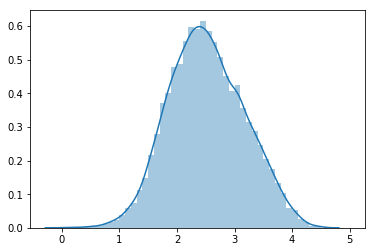

In [73]:
plot_pred(oof_train)

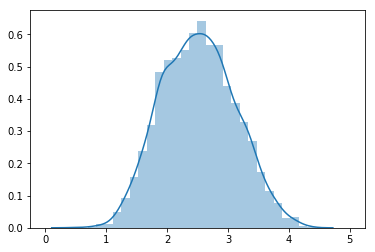

In [74]:
plot_pred(oof_test.mean(axis=1))

In [71]:
optR = OptimizedRounder_v3()
optR.fit(oof_train, X_train_non_null['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(X_train_non_null['AdoptionSpeed'].values, valid_pred)
print("QWK = ", qwk)

QWK =  0.5341874809365132


In [75]:
coefficients

array([1.3348146 , 2.02029606, 2.49295817, 3.04122789])

In [76]:
coefficients_ = coefficients.copy()
train_predictions = optR.predict(oof_train, coefficients_).astype(np.int8)
print(f'train pred distribution: {Counter(train_predictions)}')
test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_).astype(np.int8)
print(f'test pred distribution: {Counter(test_predictions)}')

train_meta_df['LGB']=oof_train
test_meta_all_df['LGB']=oof_test.mean(axis=1)

train pred distribution: Counter({3: 4087, 2: 4059, 4: 3333, 1: 3099, 0: 415})
test pred distribution: Counter({3: 1212, 2: 1031, 1: 837, 4: 799, 0: 69})


In [ ]:
plt.hist(train_predictions, bins=50)
plt.title("Test: Boundary-based Predictions")
plt.show();

plt.hist(test_predictions, bins=50)
plt.title("Test: Boundary-based Predictions")
plt.show();

In [ ]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
submission.to_csv('submission.csv', index=False)
submission.head()